<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_4_First_2D_truss_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

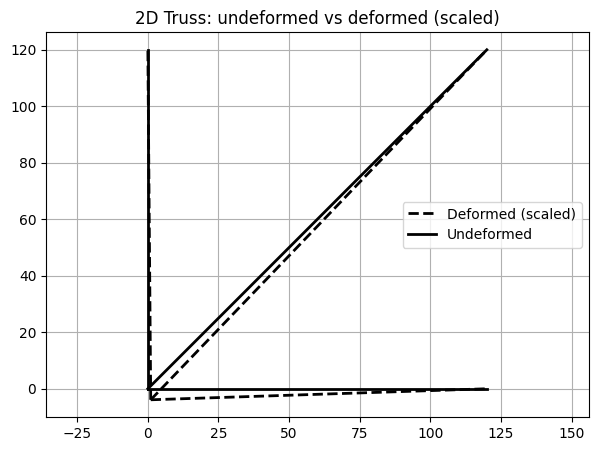

stresses
[ 3964.46609407  1464.46609407 -1035.53390593]
=== DISPLACEMENTS (U) ===
DOF 1: U = 4.142136e-03
DOF 2: U = -1.585786e-02
DOF 3: U = 0.000000e+00
DOF 4: U = 0.000000e+00
DOF 5: U = 0.000000e+00
DOF 6: U = 0.000000e+00
DOF 7: U = 0.000000e+00
DOF 8: U = 0.000000e+00

=== REACTIONS AT PRESCRIBED DOFs ===
DOF 3: R = 0.000000e+00
DOF 4: R = 7.928932e+03
DOF 5: R = 2.071068e+03
DOF 6: R = 2.071068e+03
DOF 7: R = -2.071068e+03
DOF 8: R = 0.000000e+00


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 2D Truss FEM (Problem 4) - MATLAB -> Python (Google Colab)
# FULL CODE (fixed) - copy & run in 1 cell
# ============================================================

def formStiffness2Dtruss(GDof, numberElements, elementNodes, nodeCoordinates, xx, yy, EA):
    K = np.zeros((GDof, GDof), dtype=float)

    for e in range(numberElements):
        n1, n2 = elementNodes[e, 0], elementNodes[e, 1]  # 1-based node ids

        # element dof mapping (MATLAB):
        # [n1*2-1, n1*2, n2*2-1, n2*2]
        edof = np.array([n1*2-1, n1*2, n2*2-1, n2*2], dtype=int) - 1  # -> 0-based

        xa = xx[n2-1] - xx[n1-1]
        ya = yy[n2-1] - yy[n1-1]
        L = np.sqrt(xa*xa + ya*ya)

        C = xa / L
        S = ya / L

        k1 = (EA / L) * np.array([
            [ C*C,  C*S, -C*C, -C*S],
            [ C*S,  S*S, -C*S, -S*S],
            [-C*C, -C*S,  C*C,  C*S],
            [-C*S, -S*S,  C*S,  S*S],
        ], dtype=float)

        K[np.ix_(edof, edof)] += k1

    return K


def solution(GDof, prescribedDof, stiffness, force, u_prescribed=None):
    """
    Solve KU=F with prescribed dofs (1-based like MATLAB).
    By default prescribed displacements = 0.
    """
    if u_prescribed is None:
        u_prescribed = np.zeros(len(prescribedDof), dtype=float)

    prescribed = np.array([d-1 for d in prescribedDof], dtype=int)  # 0-based
    all_dofs = np.arange(GDof, dtype=int)
    free = np.setdiff1d(all_dofs, prescribed)

    U = np.zeros(GDof, dtype=float)
    U[prescribed] = u_prescribed

    K_ff = stiffness[np.ix_(free, free)]
    K_fp = stiffness[np.ix_(free, prescribed)]
    F_f = force[free]

    rhs = F_f - K_fp @ U[prescribed]
    U[free] = np.linalg.solve(K_ff, rhs)

    return U


def drawingMesh(nodeCoordinates, elementNodes, style='k--', label=None):
    for (n1, n2) in elementNodes:
        x = [nodeCoordinates[n1-1, 0], nodeCoordinates[n2-1, 0]]
        y = [nodeCoordinates[n1-1, 1], nodeCoordinates[n2-1, 1]]
        plt.plot(x, y, style, linewidth=2, label=label)
        label = None


def stresses2Dtruss(numberElements, elementNodes, xx, yy, displacements, E):
    sigma = np.zeros(numberElements, dtype=float)

    for e in range(numberElements):
        n1, n2 = elementNodes[e, 0], elementNodes[e, 1]
        edof = np.array([n1*2-1, n1*2, n2*2-1, n2*2], dtype=int) - 1  # 0-based

        xa = xx[n2-1] - xx[n1-1]
        ya = yy[n2-1] - yy[n1-1]
        L = np.sqrt(xa*xa + ya*ya)

        C = xa / L
        S = ya / L

        u_e = displacements[edof]
        sigma[e] = (E / L) * np.array([-C, -S, C, S], dtype=float) @ u_e

    print("stresses")
    print(sigma)
    return sigma


def outputDisplacementsReactions(displacements, stiffness, GDof, prescribedDof, force):
    R = stiffness @ displacements - force

    print("=== DISPLACEMENTS (U) ===")
    for i in range(GDof):
        print(f"DOF {i+1}: U = {displacements[i]:.6e}")

    print("\n=== REACTIONS AT PRESCRIBED DOFs ===")
    for d in prescribedDof:
        print(f"DOF {d}: R = {R[d-1]:.6e}")


# ============================================================
# Main (equivalent to problem4.m)
# ============================================================

# Material
E = 30e6
A = 2.0
EA = E * A

# Mesh
numberElements = 3
numberNodes = 4

elementNodes = np.array([
    [1, 2],
    [1, 3],
    [1, 4]
], dtype=int)

nodeCoordinates = np.array([
    [0.0,   0.0],
    [0.0, 120.0],
    [120.0, 120.0],
    [120.0, 0.0]
], dtype=float)

xx = nodeCoordinates[:, 0]
yy = nodeCoordinates[:, 1]

# DOFs
GDof = 2 * numberNodes
displacements = np.zeros(GDof, dtype=float)
force = np.zeros(GDof, dtype=float)

# Applied load at node 1, y-direction (MATLAB: force(2)=-10000)
force[1] = -10000.0

# Stiffness (FIXED CALL)
stiffness = formStiffness2Dtruss(
    GDof, numberElements, elementNodes, nodeCoordinates, xx, yy, EA
)

# Boundary conditions (MATLAB: prescribedDof=[3:8])
prescribedDof = list(range(3, 9))

# Solution
displacements = solution(GDof, prescribedDof, stiffness, force)

# Drawing displacements
us = np.arange(0, GDof, 2)   # ux DOFs
vs = np.arange(1, GDof, 2)   # uy DOFs

XX = displacements[us]
YY = displacements[vs]

dispNorm = np.max(np.sqrt(XX**2 + YY**2))
scaleFact = 15000.0 * dispNorm
if dispNorm == 0:
    scaleFact = 1.0

deformed = nodeCoordinates + scaleFact * np.column_stack([XX, YY])

plt.figure(figsize=(7, 5))
plt.clf()
plt.axis('equal')
plt.grid(True)
plt.title("2D Truss: undeformed vs deformed (scaled)")

drawingMesh(deformed, elementNodes, style='k--', label='Deformed (scaled)')
drawingMesh(nodeCoordinates, elementNodes, style='k-', label='Undeformed')

plt.legend()
plt.show()

# Stresses
sigma = stresses2Dtruss(numberElements, elementNodes, xx, yy, displacements, E)

# Output displacements / reactions
outputDisplacementsReactions(displacements, stiffness, GDof, prescribedDof, force)
